### Variational Quantum Thermalizer Algorithm

The Variational Quantum Thermalizer (VQT) is a more general case of the Variational Quantum Eigensolver (VQE), for systems with non-zero temperature. Its goal is to generate the thermal state of a given Hamiltonian $H$ at an inverse temperature $\beta = 1/T$: 

$$\rho_{\beta} = \frac{e^{-\beta H}}{Z_{\beta}} = \frac{e^{-\beta H}}{\text{Tr}(e^{-\beta H})}$$

#### Theoretical Background

In order to understand the details of the VQT, I would reccomend reading [this tutorial](https://pennylane.ai/qml/demos/tutorial_vqt.html) by Jack Ceroni, from which a part of this code is based on, and the [original VQT paper](https://arxiv.org/abs/1910.02071). Here, I give a brief explanation of the algorithm's concepts. 

To implement the VQT, we begin with a density matrix $\rho_{\theta}$, defined by a set of pure states $\{ |\psi_i\rangle \}$, that constitutes a basis on a Hilbert space of dimension $d$, and a parameter vector $\theta$. Being $\{p_i(\theta_i)\}$ the probability distribution corresponding to the i-th basis state, such a matrix can be written as 
$$\rho_{\theta} = \sum_{i=1}^{d} p_i(\theta_i)|\psi_i\rangle \langle \psi_i|.$$
We sample from this distribution a pure state $|\psi_i\rangle$, pass it through a parameterised quantum circuit $U(\phi)$, and measure the mean energy  $\langle{H}\rangle_i = \langle\psi_i|{U(\phi) H U^\dag(\phi)}|\psi_i\rangle$. Repeating this process many times for the set $\{ |\psi_i \rangle, p_i(\theta_i) \}$ and averaging the obtained $\langle{H}\rangle_i$ will give us the mean energy $\langle{H}\rangle_{\theta\phi}$ with respect to $\rho_{\theta\phi} = U(\phi)\rho_{\theta}U^\dag(\phi)$:
$$\langle{H}\rangle_{\theta\phi} = \sum_{i=1}^{d} p_i(\theta_i)\langle{H}\rangle_i.$$
As in any variational algorithm, in order to find the optimal parameters  $\{ \bm{\theta}', \bm{\phi}' \}$ that solve the problem, we must find the minimum of a loss function, which here can be obtained from the mean energy and the von Neumann entropy $S(\rho_{\theta\phi}) = \text{Tr}(\rho_{\theta\phi}\ln{\rho_{\theta\phi}})$:
$$\mathcal{L}(\theta,\phi) = \beta \langle{H}\rangle_{\theta\phi} - S(\rho_{\theta\phi}),$$
which is minimized when $\rho_{\theta\phi}$ is equal to the required thermal state. This loss function would require the measurements of two quantities, but we can take advantage from the fact that the entropy is invariant under unitary transformations on the density matrix: this way only the energy measurement is necessary, as the entropy can be calculated from the probability distribution parameters $\{ \theta \}$:

$$S(\rho_{\theta\phi}) = S(U(\phi)\rho_{\theta}U^{\dag}(\phi)) = S(\rho_{\theta})$$

#### What VarQuaTh does

With VarQuaTh you can easily implement the VQT, by providing the parameters of your system and the variational circuit of your choice. It does all the steps of generating all the quantum circuits, calculating the relevant expectation values according to your probability distribution, and performing the classical optimization.

#### Implementation

First, let us begin by importing the relevant libraries for this tutorial, including VarQuaTh.

In [15]:
import numpy as np
import scipy
import seaborn as sns

#Qiskit
from qiskit import *
from qiskit.circuit.library import (
    TwoLocal,
    EfficientSU2,
    )
from qiskit.opflow import I, X, Y, Z

# For simulation
from qiskit.providers.aer import AerSimulator
from qiskit.test.mock import FakeParis

#VQT
import sys
sys.path.append('../')
from varquath import vqt

##### Hamiltonian

We are going to work with the Heisenberg Hamiltonian, defined as 

$
\begin{equation}
H = \sum_{<i,j>} X_iX_{j} + Y_iY_{j} + Z_iZ_{j},
\end{equation}
$
where $X_i$, $Y_i$ and $Z_i$ are the Pauli matrices acting in the i-th qubit, and the sum is over the neighbouring qubits. We also assume that the boundary qubits interact with each other, that is, the system presents a cyclic configuration.

We can write this hamiltonian using the `PauliOp` operators `X`,`Y` and `Z`, from the `qiskit.opflow` module (you can check more [here](https://qiskit.org/documentation/tutorials/operators/01_operator_flow.html)).

In [2]:
H = (X^X^I^I) + (Y^Y^I^I) + (Z^Z^I^I) + \
    (I^X^X^I) + (I^Y^Y^I) + (I^Z^Z^I) + \
    (I^I^X^X) + (I^I^Y^Y) + (I^I^Z^Z) + \
    (X^I^I^X) + (Y^I^I^Y) + (Z^I^I^Z)  

print(H)

1.0 * XXII
+ 1.0 * YYII
+ 1.0 * ZZII
+ 1.0 * IXXI
+ 1.0 * IYYI
+ 1.0 * IZZI
+ 1.0 * IIXX
+ 1.0 * IIYY
+ 1.0 * IIZZ
+ 1.0 * XIIX
+ 1.0 * YIIY
+ 1.0 * ZIIZ


We can also view the matricial form of the Hamiltonian using the ```.to_matrix()``` method, which returns an array that can be used to create a heatmap.

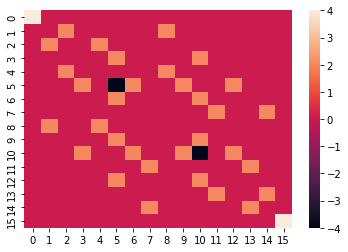

In [3]:
sns.heatmap(H.to_matrix().real);

With this set, we can choose the temperature of our system. Let us choose T = 0.5.

In [4]:
T = 0.5

beta = 1/T

Let's visualize the theoretical density matrix for the thermal state of $H$ under this temperature:

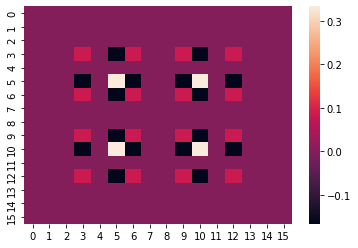

In [16]:
rho_theo = scipy.linalg.expm(-beta * H.to_matrix()) / np.trace(scipy.linalg.expm(-beta * H.to_matrix()))

sns.heatmap(rho_theo.real);

##### Ansatz

Now, we have to choose an ansatz for our problem. As all interactions are between neighboring qubits, a good choice of ansatz would only contain entangling gates between the interacting qubits (linear entanglement) and also single-qubit rotations. Thus, we can use the EfficientSU2 ansatz.   

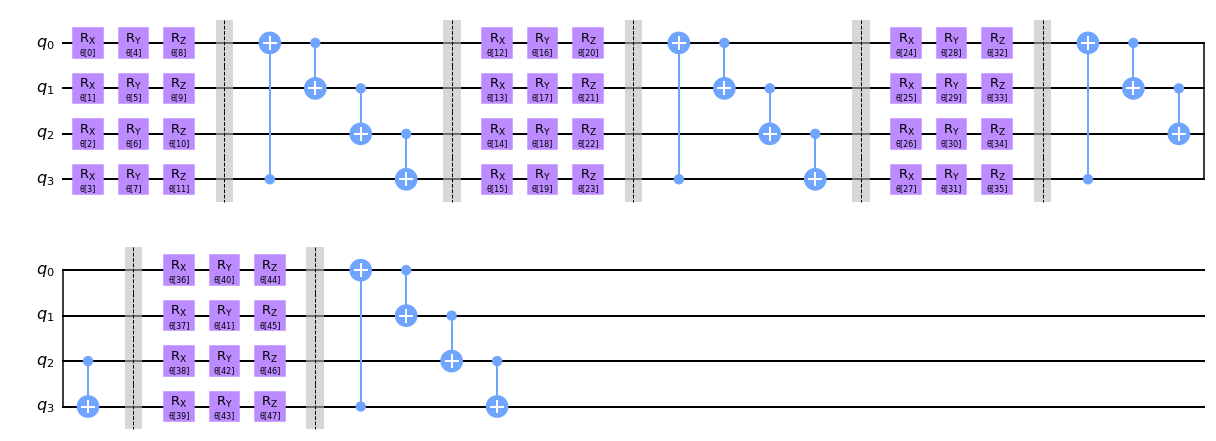

In [38]:
num_qubits = H.num_qubits # This gives the number of qubits based on the Hamiltonian's dimension

ansatz_su2 = EfficientSU2(num_qubits,
                          su2_gates=['rx', 'ry', 'rz'],
                          entanglement='circular',
                          reps=4,
                          skip_final_rotation_layer=True,
                          insert_barriers=True
                         )

ansatz_su2.decompose().draw('mpl')

Now we have to define the backend in which we will run our algorithm. For this tutorial, we will be using the `qasm_simulator` backend:

In [39]:
backend = Aer.get_backend('qasm_simulator')

Then, we must define our `VQT` instance. This class accepts as its arguments the Hamiltonian, with the `qiskit.opflow.OperatorBase` type, the value for $\beta = 1/T$, the ansatz and the backend.  

In [40]:
vqt_su2 = vqt.VQT(H, beta, ansatz_su2, backend)

Now that we have our instance defined, we can run the algorithm by calling the `.run_vqt()` method. You can set the classical optimizer (here we use COBYLA as default), its configurations, and the random seed. By setting the plot=True, the method shows a plot of the cost function minimization, which you can choose the color with the plot_color argument. 

This part can take several minutes to run, so go grab a coffee or something!

Training...
Cost at Step 0: -1.496870979292264
Cost at Step 5: -2.0737992316669915
Cost at Step 10: -2.0102078923534594
Cost at Step 15: -2.846245024987212
Cost at Step 20: -3.1614496354895367
Cost at Step 25: -3.1194623641307038
Cost at Step 30: -2.819543485173792
Cost at Step 35: -2.824371815369216
Cost at Step 40: -3.6684356612785556
Cost at Step 45: -3.677992720725018
Cost at Step 50: -2.9829132156570006
Cost at Step 55: -3.3729666370722162
Cost at Step 60: -4.78617595153924
Cost at Step 65: -4.96071339162599
Cost at Step 70: -4.8460202977407665
Cost at Step 75: -3.9971638981619577
Cost at Step 80: -5.234957307746903
Cost at Step 85: -5.730966526249283
Cost at Step 90: -5.302111428241053
Cost at Step 95: -5.144594346959577
Cost at Step 100: -5.209716832035628
Cost at Step 105: -4.807800233777707
Cost at Step 110: -5.588732733064593
Cost at Step 115: -5.561825327224294
Cost at Step 120: -5.453539748646088
Cost at Step 125: -5.617926118053768
Cost at Step 130: -6.283967747697001
Cost

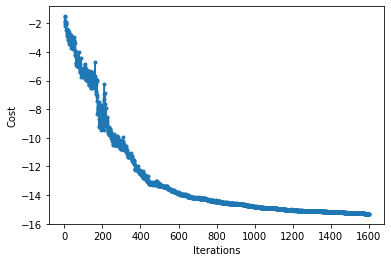

In [41]:
results_su2 = vqt_su2.run_vqt(optimizer='COBYLA', 
                              optimizer_config = {"maxiter": 1600}, 
                              random_seed=42, 
                              plot=True, 
                              plot_color='tab:blue'
                              )

Now that the algorithm has finished, we can take a look at the results. They are saved in a dictionary that contains the best ansatz parameters $\theta$ with the parameterised VQT circuits, the best $\theta$ parameters with the probability distribution found with them, and the history of the cost function classical optimization. They can also be accessed at any time by the `.get_results()` method.

In [42]:
print(results_su2.keys())

dict_keys(['ansatz_params', 'dist_params', 'prob_dist', 'best_circuits', 'history'])


Let's draw one of the parameterised circuits:

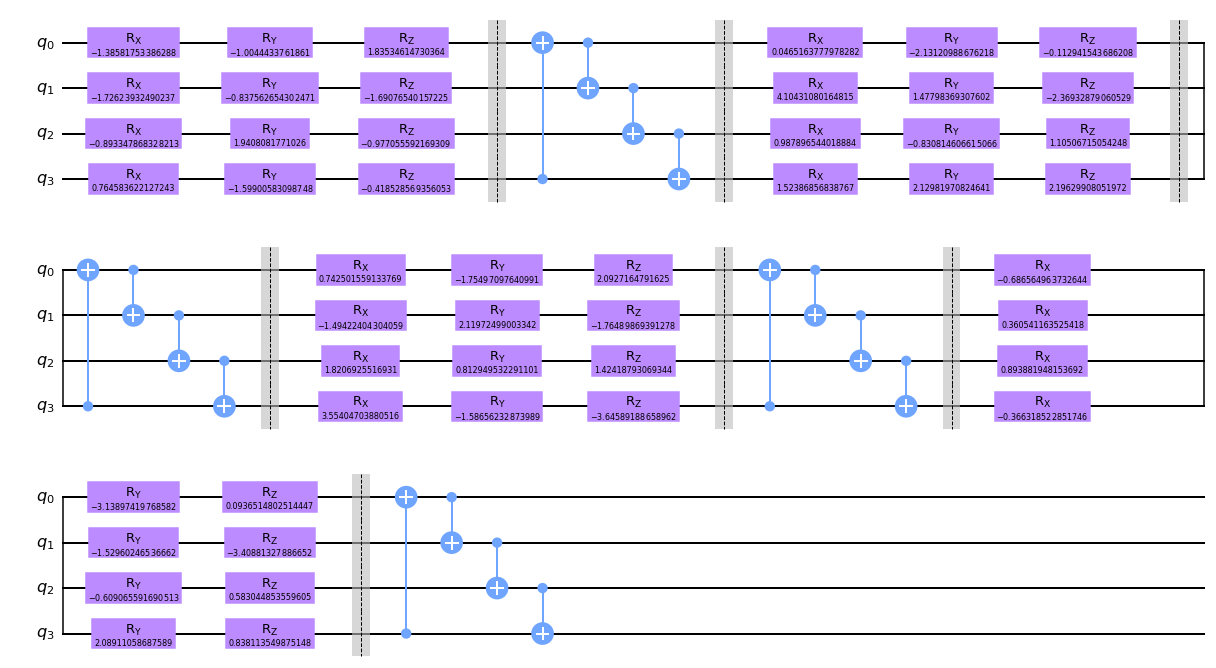

In [43]:
results_su2["best_circuits"][0].decompose().decompose().draw('mpl')

Finally, we can get the density matrix by calling the `.get_density_matrix()` method on our VQT instance. It can also return the fidelity by setting the argument `fidelity = True`. 

What the method does is to perform a quantum state tomography in all the VQT circuits, followed by a weighted sum with their respective probabilities.

In [46]:
density_matrix_su2, fidelity_su2 = vqt_su2.get_density_matrix(fidelity=True)

Fidelity EfficientSU2:  0.9234706353660566


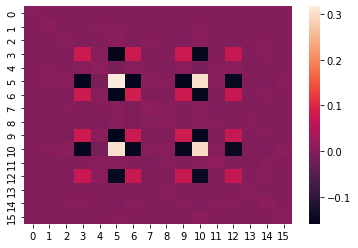

In [47]:
print("Fidelity EfficientSU2: ", fidelity_su2)
sns.heatmap(density_matrix_su2.real);

The closer to 1, the better. Thus, with a fidelity of around 0.92, we were able to create a good approximation to the thermal state using the VQT.

##### Trying different ansatzes
What if we try other ansatzes? The EfficientSU2 entangling gates are CNOTS, which don't have any parameter. Let's see if we get any improvement in our results by parameterizing the entangling gates, switching the CNOTs with controlled-Rx gates. For this, we can use the TwoLocal ansatz: 

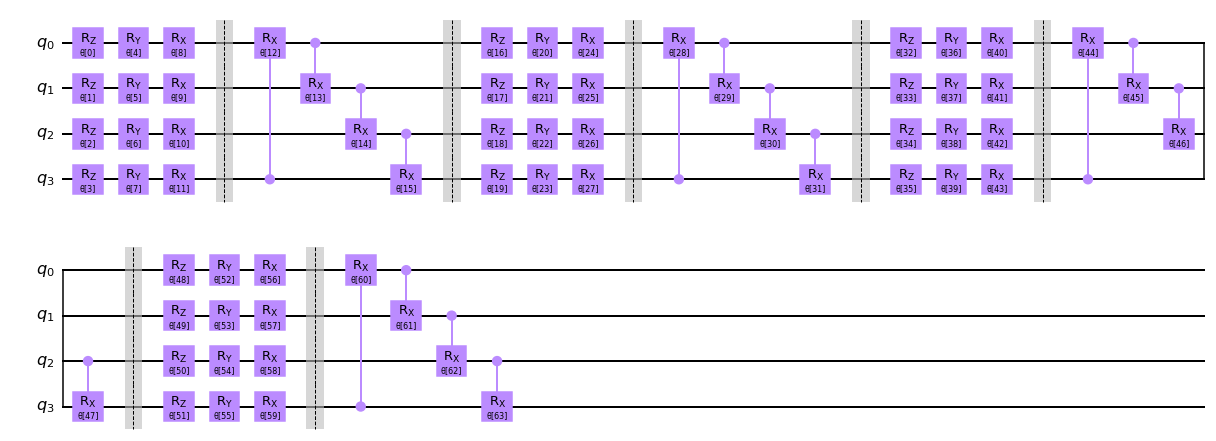

In [30]:
ansatz_twolocal = TwoLocal(num_qubits, 
                           rotation_blocks=['rz', 'ry', 'rx'], 
                           entanglement_blocks = ['crx'],
                           entanglement=['circular'],
                           reps = 4,
                           skip_final_rotation_layer=True,
                           insert_barriers=True
                           )

ansatz_twolocal.decompose().draw('mpl')

Training...
Cost at Step 0: -1.739047329672522
Cost at Step 5: -2.259556111194188
Cost at Step 10: -2.3255401183353532
Cost at Step 15: -2.826694813372091
Cost at Step 20: -3.3170528328366844
Cost at Step 25: -3.324755325506066
Cost at Step 30: -3.349556480465414
Cost at Step 35: -3.164552925738464
Cost at Step 40: -3.4476723085466654
Cost at Step 45: -3.4894183978086986
Cost at Step 50: -3.68700096216312
Cost at Step 55: -3.6317881905951452
Cost at Step 60: -3.482976527725101
Cost at Step 65: -4.111355474867482
Cost at Step 70: -4.04286122972932
Cost at Step 75: -4.83122370668418
Cost at Step 80: -4.831223706684179
Cost at Step 85: -4.694627132511663
Cost at Step 90: -4.901214567320945
Cost at Step 95: -5.054349712692466
Cost at Step 100: -5.036353169943711
Cost at Step 105: -4.48811355086978
Cost at Step 110: -5.118254044627255
Cost at Step 115: -4.642978846252472
Cost at Step 120: -5.239031911192308
Cost at Step 125: -4.809449064699287
Cost at Step 130: -5.248298101562337
Cost at St

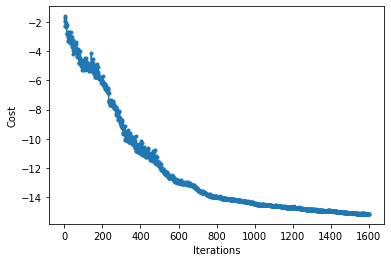

In [31]:
vqt_twolocal = vqt.VQT(H, beta, ansatz_twolocal, backend)

results_twolocal = vqt_twolocal.run_vqt(optimizer_config = {"maxiter": 1600})

Fidelity TwoLocal:  0.8921818795856136


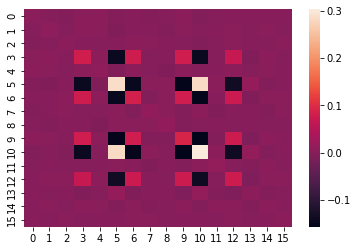

In [32]:
density_matrix_twolocal, fidelity_twolocal = vqt_twolocal.get_density_matrix(fidelity=True)

print("Fidelity TwoLocal: ", fidelity_twolocal)
sns.heatmap(density_matrix_twolocal.real);

We don't seem to get much improvement here. Actually, it looks like a worse choice of ansatz: it doesn't yields better results, and takes longer to run due to the increased number of parameters.

Finally, let's try a different approach: using only Ry rotations and controlled Ry gates. It will reduce the depth of the circuit and the number of parameters, but the rotations will be performed around a single axis.

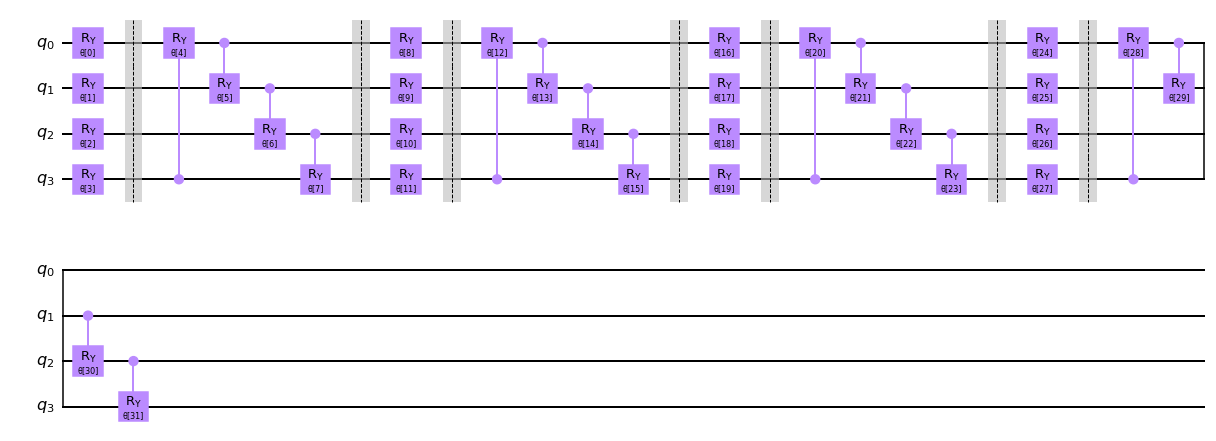

In [70]:
ansatz_twolocal_ry = TwoLocal(num_qubits, 
                         rotation_blocks=['ry'], 
                         entanglement_blocks = ['cry'],
                         entanglement=['circular'],
                         reps = 4,
                         skip_final_rotation_layer=True,
                         insert_barriers=True
                        )

ansatz_twolocal_ry.decompose().draw('mpl')

Training...
Cost at Step 0: -2.3138402921139423
Cost at Step 5: -3.020079743761971
Cost at Step 10: -2.9823108267301963
Cost at Step 15: -3.4603684583688756
Cost at Step 20: -3.1689536673264946
Cost at Step 25: -3.6829216154078934
Cost at Step 30: -3.7014177976535816
Cost at Step 35: -4.175771908665903
Cost at Step 40: -6.024466428916199
Cost at Step 45: -5.864830472449025
Cost at Step 50: -7.243849036053788
Cost at Step 55: -6.7999820553375585
Cost at Step 60: -6.8736750378282
Cost at Step 65: -8.593580604990523
Cost at Step 70: -8.41366336955994
Cost at Step 75: -7.453026972093106
Cost at Step 80: -9.205523326083338
Cost at Step 85: -8.150310420254517
Cost at Step 90: -9.413770794058777
Cost at Step 95: -9.50116713530947
Cost at Step 100: -10.431146079950237
Cost at Step 105: -8.61968218396001
Cost at Step 110: -9.950852168855981
Cost at Step 115: -8.817419602326527
Cost at Step 120: -9.961115763430147
Cost at Step 125: -10.649928764876913
Cost at Step 130: -10.380869803765394
Cost a

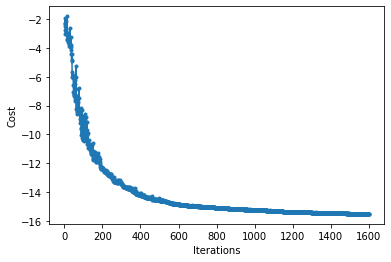

In [28]:
vqt_twolocal_ry = vqt.VQT(H, beta, ansatz_twolocal_ry, backend)

results_twolocal_ry = vqt_twolocal_ry.run_vqt(optimizer_config = {"maxiter": 1600})

Fidelity TwoLocal:  0.9298394291849064


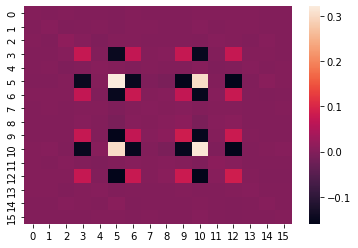

In [29]:
density_matrix_twolocal_ry, fidelity_twolocal_ry = vqt_twolocal_ry.get_density_matrix(fidelity=True)

print("Fidelity TwoLocal: ", fidelity_twolocal_ry)
sns.heatmap(density_matrix_twolocal_ry.real);

That's very interesting: it seems that this simpler ansatz yields a result as good as the EfficientSU2 ansatz, but with smaller depth and less parameters, which can be good if we try to run it in noisy devices.

But this is not the end of the story: there may be ansatzes better than these tested here. Why don't you try and find out for yourself? You can investigate ansatzes with different combinations of gates, depths and number of parameters. Have fun!

#### References

- Verdon, G., Marks, J., Nanda, S., Leichenauer, S., & Hidary, J. (2019). Quantum Hamiltonian-based models and the variational quantum thermalizer algorithm. arXiv preprint arXiv:1910.02071.

- https://pennylane.ai/qml/demos/tutorial_vqt.html (visited june 2022)